In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

In [ ]:
xs = np.arange(-5, 5, 0.25)

In [ ]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
ys = f(xs)

In [ ]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

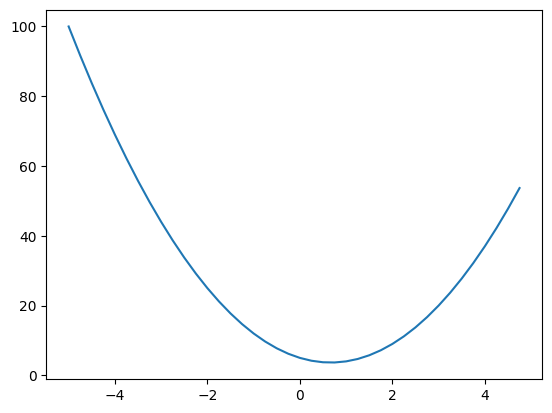

In [ ]:
plt.plot(xs, ys)

In [ ]:
h = 0.001
x = 2/3
(f(x + h) - f(x)) / h

0.0029999999995311555

In [ ]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) /h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [ ]:
class Value:

  def __init__(self, data, _children=(), _op = "", label = ""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,  other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value( self.data + other.data, (self, other), "+" )

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __mul__(self,  other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value( self.data * other.data, (self, other), "*" )

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __radd__(self, other): # other + self
    return self + other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [ ]:
a = Value(2.0, label = "a")
b = Value(4.0)

a - b


Value(data=-2.0)

In [ ]:
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
c = Value(10.0, label = "c")
e = a*b ; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f ; L.label="L"
L

# a.__mul__(b).__add__(c)

Value(data=-8.0)

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op

'+'

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  print("nodes: ", nodes)
  print("edges: ", edges)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

nodes:  {Value(data=4.0), Value(data=-6.0), Value(data=2.0), Value(data=-2.0), Value(data=-8.0), Value(data=10.0), Value(data=-3.0)}
edges:  {(Value(data=10.0), Value(data=4.0)), (Value(data=-6.0), Value(data=4.0)), (Value(data=-2.0), Value(data=-8.0)), (Value(data=4.0), Value(data=-8.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0))}


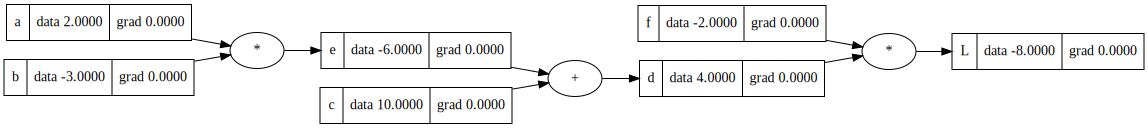

In [ ]:
# @title
draw_dot(L)

In [ ]:
# @title
"""
L = d*f

what is dL/dd

Mathematically, it is (f(x+h) - f(x)) / h

((d+h)*f - d*f ) / h
(d*f + h*f - d*f) / h
h*f / h
f
"""

'\nL = d*f\n\nwhat is dL/dd\n\nMathematically, it is (f(x+h) - f(x)) / h\n\n((d+h)*f - d*f ) / h\n(d*f + h*f - d*f) / h\nh*f / h\nf\n'

In [ ]:
# @title
print("{ data %.4f  }" % (5.66899756))

{ data 5.6690  }


In [ ]:
# @title
L.grad = 1

In [ ]:
# @title
def lol():

  h = 0.00001


  a = Value(2.0, label = "a")
  b = Value(-3.0, label = "b")
  c = Value(10.0, label = "c")
  e = a*b ; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f ; L.label="L"
  L1 = L.data

  a = Value(2.0 , label = "a")
  b = Value(-3.0, label = "b")
  c = Value(10.0, label = "c")
  e = a*b ; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f ; L.label="L"
  L2 = L.data + h

  print((L2 - L1) / h)


lol()

0.9999999999621422


In [ ]:
# @title
"""
L = d*f

what is dL/dd ?

Mathematically, it is (f(x+h) - f(x)) / h

((d+h)*f - d*f ) / h
(d*f + h*f - d*f) / h
h*f / h
f

Symmetrically, dL/df = d
"""
d.grad = -2
f.grad = 4


In [ ]:
# @title
"""
dd/dc = ?

d = c+ e
Mathematically, it is (f(x+h) - f(x)) / h

((c+h)+e - (c + e)) / h
( c + h + e - c - e ) / h
h / h
1.0

dd/dc = 1.0

Symmetrically, dd/de = 1.0

We want dL/dc.
We know:
dL/dd, dd/dc. so?

dL/dc = (dL / dd) * (dd / dc)
"""
c.grad = -2
e.grad = -2

nodes:  {Value(data=4.0), Value(data=-6.0), Value(data=2.0), Value(data=-2.0), Value(data=-8.0), Value(data=10.0), Value(data=-3.0)}
edges:  {(Value(data=10.0), Value(data=4.0)), (Value(data=-6.0), Value(data=4.0)), (Value(data=-2.0), Value(data=-8.0)), (Value(data=4.0), Value(data=-8.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0))}


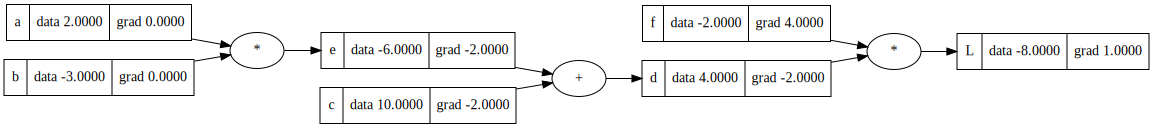

In [ ]:
# @title
draw_dot(L)

In [ ]:
# @title
"""
We want dL/da.
We know:
dL/de. so?

dL/da = (dL / de) * (de / da)

e = a*b
de / da = b
dL/da = -2 * b
dL/da = 6

Similarly,
dL/db = (dL / de) * (de / db)
dL/db = -2 * a
dL/db = -4
"""
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2


nodes:  {Value(data=4.0), Value(data=-6.0), Value(data=2.0), Value(data=-2.0), Value(data=-8.0), Value(data=10.0), Value(data=-3.0)}
edges:  {(Value(data=10.0), Value(data=4.0)), (Value(data=-6.0), Value(data=4.0)), (Value(data=-2.0), Value(data=-8.0)), (Value(data=4.0), Value(data=-8.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0))}


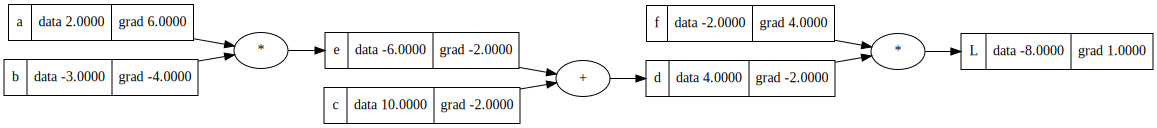

In [ ]:
# @title
draw_dot(L)

In [ ]:
# @title
"""
We will nudge our inputs that will make L go up. By what?
We need to go up in the direction of the grdient. Positive change for positive gradient & vice-versa.
"""
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Doing another forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


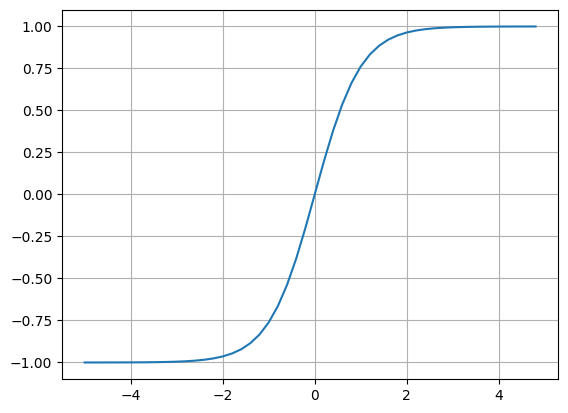

In [ ]:
# @title
"""
An activation function is a squashing function that squashes the input between two values.
Like in this example, tanh does it between -1 and 1
"""

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
o.backward()


nodes:  {Value(data=0.8813735870195432), Value(data=6.881373587019543), Value(data=-6.0), Value(data=-3.0), Value(data=0.7071067811865476), Value(data=0.0), Value(data=0.0), Value(data=2.0), Value(data=-6.0), Value(data=1.0)}
edges:  {(Value(data=-3.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=0.0), Value(data=0.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=0.0), Value(data=-6.0)), (Value(data=0.8813735870195432), Value(data=0.7071067811865476)), (Value(data=1.0), Value(data=0.0)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=6.881373587019543), Value(data=0.8813735870195432))}


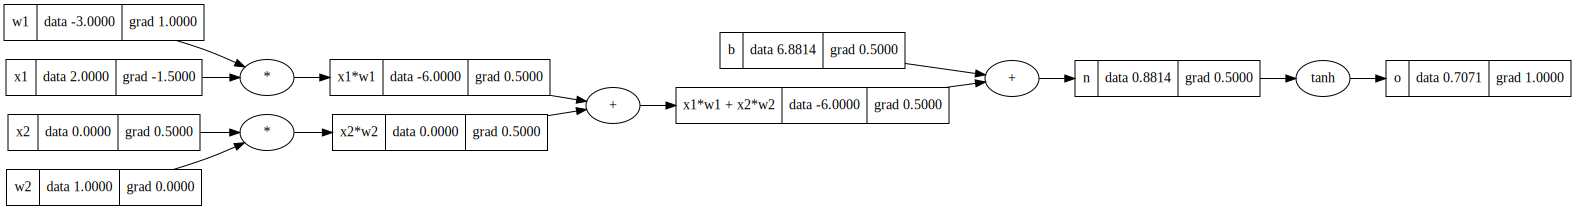

In [ ]:
draw_dot(o)

nodes:  {Value(data=0.7071067811865477), Value(data=1), Value(data=-6.0), Value(data=4.828427124746192), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=-1), Value(data=0.1464466094067262), Value(data=-3.0), Value(data=6.881373587019543), Value(data=1.7627471740390863), Value(data=2.0), Value(data=1.0), Value(data=5.828427124746192), Value(data=6.828427124746192), Value(data=0.0), Value(data=2), Value(data=0.0)}
edges:  {(Value(data=-3.0), Value(data=-6.0)), (Value(data=5.828427124746192), Value(data=4.828427124746192)), (Value(data=5.828427124746192), Value(data=6.828427124746192)), (Value(data=1), Value(data=6.828427124746192)), (Value(data=2.0), Value(data=-6.0)), (Value(data=0.1464466094067262), Value(data=0.7071067811865477)), (Value(data=0.0), Value(data=0.0)), (Value(data=0.8813735870195432), Value(data=1.7627471740390863)), (Value(data=2), Value(data=1.7627471740390863)), (Value(data=-1), Value(data=4.828427124746192)), (Value(data=0.0), Value(data=-6.0)), (Value(d

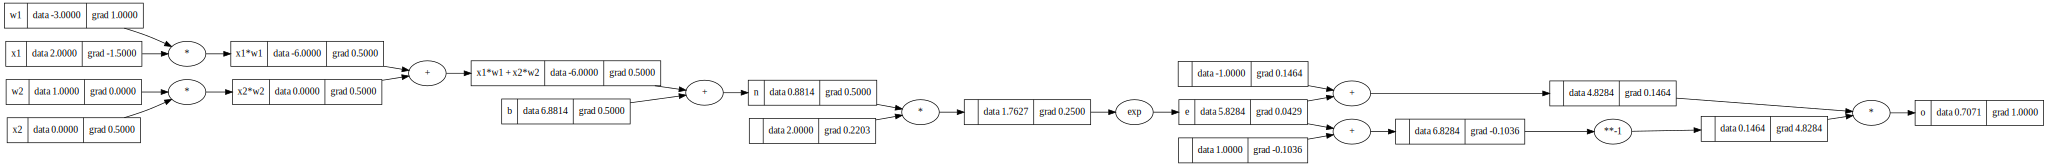

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Now implementing tanh using exp
e = (2*n).exp(); e.label= 'e'
o = (e - 1) / (e + 1); o.label= 'o'

o.backward()
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
# @title
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2),
 Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=-1),
 Value(data=4.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=0.7071067811865477)]

In [ ]:
# @title
n._backward()

In [ ]:
# @title
b._backward()

In [ ]:
# @title
x1w1x2w2._backward()

In [ ]:
# @title
x1w1._backward()

In [ ]:
# @title
x2w2._backward()

In [ ]:
# @title
"""
o = tanh(n)
do/dn = ?

do/dn = 1 - tanh(n)**2
d0/dn = 1 - o**2    ....{because, we already know tanh(n) = o}

As we calculated, it turns out that n.grad = 0.5
"""
n.grad = 0.5

In [ ]:
# @title
"""
We have already seen that a '+' operation will just carry forward the gradient.
So, gradients for all the nodes involves in the expression x1*w1 + x2*w2 + b will be the same as n.grad.
"""
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
# @title
"""
We have already seen that a '+' operation will just carry forward the gradient.
So, gradients for all the nodes involves in the expression x1*w1 & x2*w2 will be the same as x1w1x2w2.grad.
"""
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
# @title
"""
Again following the multiplication chain rule, we find gradients for x1, w1, x2 and w2.
"""
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

nodes:  {Value(data=6.0), Value(data=3.0)}
edges:  {(Value(data=3.0), Value(data=6.0))}


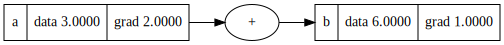

In [ ]:
"""
This is an exercise to show a bug in the code.

In all the arthemetic functions (add, mul & tanh), we assigned the gradient to the self.grad of thevalue object.
If the variable is used more than once, when the gradient is calculated the second time, the second gradient overrides the first gradient.
To avoid this, we should accumulate the gradient.
"""

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

nodes:  {Value(data=-2.0), Value(data=1.0), Value(data=-6.0), Value(data=-6.0), Value(data=3.0)}
edges:  {(Value(data=3.0), Value(data=-6.0)), (Value(data=-2.0), Value(data=1.0)), (Value(data=1.0), Value(data=-6.0)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=-2.0), Value(data=-6.0)), (Value(data=3.0), Value(data=1.0))}


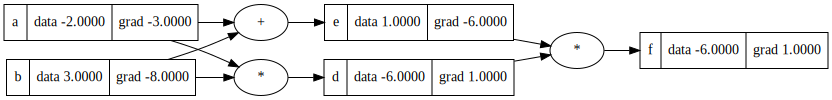

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

## Some trivia
Conceptually, thinking about the training process of forward pass, calculating the loss, backprop, nudge on modern NNs with billions of parameters: from a computation standpoint, this requires many simultaneous reads from and updates to memory to/from the CPU/GPU, even for a single pass of data. Thinking from first principles, it would seem advantageous to assemble a custom computer architecture that would allow the entire NN math function (with billions of parameters) to remain in computational memory (registers) while doing forward and back propagation, thus saving time trying to load/unload/store updated values for weights and biases?

Is there a company that's attempting to accomplish such a feat?


### Andrej's response
current computer architectures spend most of their time and energy shuttling data to/from memory, through the "von Neumann bottleneck", and calculating little pieces of the neural net at a time. this is not how it should be laid out and it is not how the brain works either, and yes many people are aware and working out various improvements. basically, "classical software" and "neural net software" need very different hardware for optimum efficiency and all the neural nets today run in "emulation mode".

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
print(o)
print(o.data)
print(o.data.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
tensor([0.7071], dtype=torch.float64)
0.7071066904050358


In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

n(x)

Value(data=0.7634857451764663)

In [ ]:
# w = [1,2,3,4]
# x = [4,3,2,1]

# for i in list(zip(w, x)):
#   print(i[1])

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(20):

  # Implemention of the forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # Implementation of the backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # Update with gradient . Nudge
  for p in n.parameters():
    p.data += -0.5* p.grad

  print(k, loss.data)

0 0.012698319672555882
1 0.012061631712660458
2 0.011485439209702325
3 0.010961502882010747
4 0.010483017128918855
5 0.010044310701000455
6 0.009640619464378558
7 0.009267911758023755
8 0.008922752653637706
9 0.008602197358701645
10 0.00830370670729584
11 0.008025079571957895
12 0.007764398367677941
13 0.007519984779156276
14 0.007290363539701379
15 0.007074232602231942
16 0.006870438422879675
17 0.006677955362470974
18 0.006495868426525107
19 0.006323358728658088


In [ ]:
ypred

[Value(data=0.9662938686512286),
 Value(data=-0.9501545651352384),
 Value(data=-0.9633702016490333),
 Value(data=0.9631089992807489)]

In [ ]:
# Implementation of the backward pass
loss.backward()

In [ ]:
# Update with gradient . Nudge
for p in n.parameters():
  p.data += -0.01* p.grad